In [1]:
from pathlib import Path
import yaml
import pandas as pd
#from utils import collect_res_dat
import copy

import warnings


In [2]:
#x = baselines vs best in2v variant

def get_table_x(df):
    params = []
    for c in df.drop(["val_acc", "test_acc", "statrep", "trained_epochs"], axis=1).columns:
        if len(df[c].unique())>1:
            params.append(c)
    tmp = df.groupby(params)
    mean = tmp.mean(numeric_only = True)
    std = tmp.std(numeric_only = True)
    
    ix = mean.val_acc.idxmax()
    num_occ = mean.val_acc.value_counts()[mean.loc[ix].val_acc]
    
    #check wether max is unique, if not use lowest sd one
    if num_occ > 1:
        max_df = mean[mean.val_acc.eq(mean.loc[ix].val_acc)]
        for index, row in max_df.iterrows():
            if std.loc[index].val_acc < std.loc[ix].val_acc:
                ix = index
    return (mean.loc[ix].test_acc*100, std.loc[ix].test_acc*100)
    
prbest = lambda x: "$\\mathbf{{{:.2f}}}_{{{:.2f}}}$".format(x[0], x[1])
prother = lambda x: "${:.2f}_{{{:.2f}}}$".format(x[0], x[1])

def print_res_x(dss, splits = ["145", "24", "43", "81"], model = "Sage", datamode = "emb"):
    for ds in dss:
        ls_orig, ls_trans, ls_fp, ls_train, ls_best = ["\\textcolor{gray}{Original features"], ["\\textcolor{gray}{N2V (transductive)"], ["Feature Propagation"], ["N2V (inductive)"], ["\\textbf{iN2V} (own)"]
        for split in splits:
            tmp = "../results_comb/F_"+ds+"_"+split+"_"+model
            ls = [pd.read_pickle(tmp+".pkl")]
            if Path(tmp+"_e.pkl").exists():
                ls.append(pd.read_pickle(tmp+"_e.pkl"))
            if Path(tmp+"_jk.pkl").exists():
                ls.append(pd.read_pickle(tmp+"_jk.pkl"))
            if Path(tmp+"_fp.pkl").exists():
                ls.append(pd.read_pickle(tmp+"_fp.pkl"))
            if Path(tmp+"_tr.pkl").exists():
                ls.append(pd.read_pickle(tmp+"_tr.pkl"))

            
            
            df = pd.concat(ls, ignore_index=True).drop([
                "val_loss", "test_loss", "loss_hist", "valtest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                "context_size", "num_negative_samples", "max_iter", "patience"], axis=1, errors="ignore")

            
            ls_orig.append(prother(get_table_x(df[df.datamode.eq("gra")])))
            ls_trans.append(prother(get_table_x(df[df.datamode.eq(datamode+"_transd")])))
            
            res_ls = [get_table_x(df[df.datamode.eq(datamode+"_fpbase")]), get_table_x(df[df.datamode.eq(datamode+"_tr")]), get_table_x(df[df.datamode.eq(datamode+"_po") | df.datamode.eq(datamode+"_lo") | df.datamode.eq(datamode+"_re") | df.datamode.eq(datamode+"_ba")])]
            mx = max(res_ls)[0]
            res_ls=[prbest(x) if x[0]==mx else prother(x) for x in res_ls]

            ls_fp.append(res_ls[0])
            ls_train.append(res_ls[1])
            ls_best.append(res_ls[2])
            
        ds_n = {"Cora":"Cora", "Cite":"Citeseer", "PM":"Pubmed", "Com":"Computers", "Pho":"Photo", "Act":"Actor", "Ar":"Amazon-ratings", "Re":"Roman-empire", "WCS":"WikiCS"}[ds]

        print(r"\multicolumn{"+str(len(ls_orig))+"}{l}{"+ds_n+"} \\\\ \\hline")
        print(" & ".join(ls_train)+" \\\\")
        print(" & ".join(ls_fp)+" \\\\")
        print(" & ".join(ls_best)+" \\\\ \\hline")
        print("} & \\textcolor{gray}{".join(ls_orig)+"} \\\\")
        print("} & \\textcolor{gray}{".join(ls_trans)+"} \\\\ \\midrule")
        print()

In [3]:
#aggregate over all datasets
def aggregate_res():
    res_ls = []
    for model in ["MLP", "Sage"]:
        for ds in ["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"]:
            for split in ["145", "24", "43","62", "81"]:
                tmp = "../results_comb/F_"+ds+"_"+split+"_"+model
                ls = [pd.read_pickle(tmp+".pkl")]
                if Path(tmp+"_e.pkl").exists():
                    ls.append(pd.read_pickle(tmp+"_e.pkl"))
                if Path(tmp+"_jk.pkl").exists():
                    ls.append(pd.read_pickle(tmp+"_jk.pkl"))
                if Path(tmp+"_fp.pkl").exists():
                    ls.append(pd.read_pickle(tmp+"_fp.pkl"))
                if Path(tmp+"_tr.pkl").exists():
                    ls.append(pd.read_pickle(tmp+"_tr.pkl"))
                df = pd.concat(ls, ignore_index=True).drop([
                    "val_loss", "test_loss", "loss_hist", "valtest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                    "context_size", "num_negative_samples", "max_iter", "patience"], axis=1, errors="ignore")
                

                for cat in ["emb", "cat"]:
                    tmp = get_table_x(df[df.datamode.eq("gra")])
                    res_ls.append((ds, split, model, cat, "gra", tmp[0], tmp[1]))
                    for datamode in ["transd", "fpbase", "fploss", "fpprob", "tr", "ba", "po", "lo", "re"]:
                        tmp = get_table_x(df[df.datamode.eq(cat+"_"+datamode)])
                        res_ls.append((ds, split, model, cat, datamode, tmp[0], tmp[1]))
    return pd.DataFrame(res_ls, columns =['dataset', 'split', 'model', "cat", "datamode", "test_acc", "std"])

In [4]:
res_df = aggregate_res()


In [5]:
df = copy.copy(res_df)
df.datamode = df.datamode.replace({"tr":"N2V (in.)", "fpbase":"FP", "ba":"frozen ($\\lambda=1$)","po":"post-hoc", "lo":"p-h w losses", "re":"p-h w sampling", "gra":"features only", "transd":"N2V (tr.)"})
df.model = df.model.replace({"Sage":"GraphSAGE"})
df.split = df.split.replace({"145":10, "24":20, "43":40, "62":60, "81":80, })


/tmp/ipykernel_93552/1099724808.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.split = df.split.replace({"145":10, "24":20, "43":40, "62":60, "81":80, })


In [117]:
#sage vs mlp
#cat vs emb
tmp = df[df.datamode.ne("fploss")&df.datamode.ne("fpprob")].groupby(["cat", "model", "datamode"]).mean(numeric_only=True).reset_index()
print(tmp.pivot(index='datamode', columns=["cat", "model"], values='test_acc').to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrr}
\toprule
cat & \multicolumn{2}{r}{cat} & \multicolumn{2}{r}{emb} \\
model & GraphSAGE & MLP & GraphSAGE & MLP \\
datamode &  &  &  &  \\
\midrule
FP & 74.09 & 73.17 & 63.20 & 62.97 \\
N2V (in.) & 73.51 & 68.72 & 59.45 & 27.91 \\
N2V (tr.) & 75.57 & 74.15 & 65.07 & 63.89 \\
features only & 74.73 & 71.01 & 74.73 & 71.01 \\
frozen ($\lambda=1$) & 73.46 & 72.40 & 62.88 & 61.74 \\
p-h w losses & 74.32 & 74.04 & 63.95 & 64.57 \\
p-h w sampling & 74.02 & 73.95 & 63.83 & 64.42 \\
post-hoc & 74.24 & 73.99 & 63.75 & 64.38 \\
\bottomrule
\end{tabular}



In [118]:
df=df[df.cat.eq("emb")]
df=df[df.datamode.eq("fploss")|df.datamode.eq("fpprob")|df.datamode.eq("FP")]
df

,dataset,split,model,cat,datamode,test_acc,std
2,Cora,10,MLP,emb,FP,78.539786,1.423613
3,Cora,10,MLP,emb,fploss,79.269893,1.275014
4,Cora,10,MLP,emb,fpprob,79.204266,1.550839
22,Cora,20,MLP,emb,FP,81.108032,1.170562
23,Cora,20,MLP,emb,fploss,80.443212,1.371501
...,...,...,...,...,...,...,...
1763,Re,60,GraphSAGE,emb,fploss,16.045896,1.300203
1764,Re,60,GraphSAGE,emb,fpprob,15.584731,1.790754
1782,Re,80,GraphSAGE,emb,FP,21.968226,1.251630
1783,Re,80,GraphSAGE,emb,fploss,21.959400,1.801289


In [119]:
print(df.groupby(["model", "datamode"]).mean(numeric_only=True).reset_index().pivot(index='datamode', columns=["model"], values='test_acc').to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrr}
\toprule
model & GraphSAGE & MLP \\
datamode &  &  \\
\midrule
FP & 63.20 & 62.97 \\
fploss & 63.22 & 63.04 \\
fpprob & 62.98 & 62.98 \\
\bottomrule
\end{tabular}



In [6]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

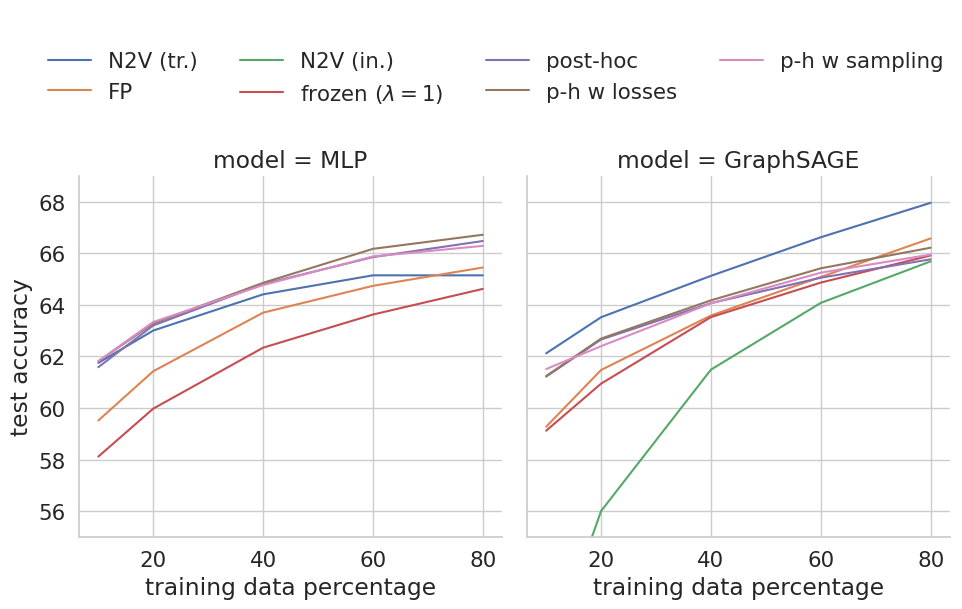

In [7]:
#hom_df = df[df.dataset.ne("Actor") & df.dataset.ne("Amazon-rating") & df.dataset.ne("Roman-empire")]
ta = "test accuracy"
n_sp = "training data percentage"

tmp_df = df[df.cat.eq("emb") & df.datamode.ne("features only")& df.datamode.ne("fpprob")& df.datamode.ne("fploss")].rename(columns={"test_acc":ta, "datamode":"setup"})

sns.set(font_scale=1.4)
sns.set_style("whitegrid")

fg = sns.relplot(tmp_df.rename(columns={"setup":" ", "split":n_sp}), x=n_sp, y=ta, hue=" ", kind="line",col="model", errorbar=None, facet_kws={'sharey': True, 'sharex': True})
sns.move_legend(fg, "lower center", bbox_to_anchor=(.43, 1), ncol=4)

plt.ylim(55,69)
plt.savefig("imgs/split_effect.pdf", bbox_inches='tight')

In [10]:
print_res_x(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"])

\multicolumn{5}{l}{Cora} \\ \hline
N2V (inductive) & $42.18_{3.52}$ & $59.91_{4.15}$ & $75.07_{1.92}$ & $\mathbf{84.50}_{1.44}$ \\
Feature Propagation & $77.91_{2.62}$ & $79.48_{2.19}$ & $81.03_{1.85}$ & $84.13_{2.35}$ \\
\textbf{iN2V} (own) & $\mathbf{78.88}_{1.45}$ & $\mathbf{80.94}_{1.58}$ & $\mathbf{83.30}_{1.09}$ & $84.46_{2.08}$ \\ \hline
\textcolor{gray}{Original features} & \textcolor{gray}{$75.27_{2.63}$} & \textcolor{gray}{$83.37_{1.17}$} & \textcolor{gray}{$86.23_{1.77}$} & \textcolor{gray}{$87.05_{1.20}$} \\
\textcolor{gray}{N2V (transductive)} & \textcolor{gray}{$79.25_{1.45}$} & \textcolor{gray}{$81.66_{1.29}$} & \textcolor{gray}{$83.81_{0.95}$} & \textcolor{gray}{$86.01_{1.99}$} \\ \midrule

\multicolumn{5}{l}{Citeseer} \\ \hline
N2V (inductive) & $34.17_{3.43}$ & $42.76_{2.15}$ & $56.12_{3.24}$ & $68.89_{2.61}$ \\
Feature Propagation & $56.85_{1.84}$ & $60.53_{2.03}$ & $\mathbf{63.03}_{2.21}$ & $\mathbf{69.76}_{1.82}$ \\
\textbf{iN2V} (own) & $\mathbf{57.88}_{0.91}$ & $

In [6]:
print_res_x(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "MLP", datamode = "emb")

\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $30.04_{1.06}$ & $30.07_{1.15}$ & $30.12_{1.05}$ & $29.67_{1.04}$ & $30.70_{2.14}$ \\
Feature Propagation & $78.54_{1.42}$ & $81.11_{1.17}$ & $82.38_{1.01}$ & $83.76_{1.00}$ & $85.13_{2.27}$ \\
\textbf{iN2V} (own) & $\mathbf{79.84}_{1.27}$ & $\mathbf{81.70}_{1.19}$ & $\mathbf{83.93}_{1.16}$ & $\mathbf{84.69}_{0.95}$ & $\mathbf{85.57}_{2.22}$ \\ \hline
\textcolor{gray}{Original features} & \textcolor{gray}{$66.98_{1.70}$} & \textcolor{gray}{$71.34_{1.79}$} & \textcolor{gray}{$75.94_{1.38}$} & \textcolor{gray}{$78.78_{1.11}$} & \textcolor{gray}{$79.23_{1.95}$} \\
\textcolor{gray}{N2V (transductive)} & \textcolor{gray}{$78.44_{1.15}$} & \textcolor{gray}{$80.84_{1.49}$} & \textcolor{gray}{$82.82_{1.10}$} & \textcolor{gray}{$83.75_{1.20}$} & \textcolor{gray}{$83.10_{1.86}$} \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $19.81_{1.75}$ & $21.43_{1.00}$ & $21.11_{1.27}$ & $21.10_{1.46}$ & $19.82_{3.05}$ \\
Feature Pro

In [7]:
print_res_x(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "Sage", datamode = "emb")

\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $42.18_{3.52}$ & $59.91_{4.15}$ & $75.07_{1.92}$ & $81.31_{1.56}$ & $\mathbf{84.50}_{1.44}$ \\
Feature Propagation & $77.91_{2.62}$ & $79.48_{2.19}$ & $81.03_{1.85}$ & $\mathbf{84.00}_{1.00}$ & $84.13_{2.35}$ \\
\textbf{iN2V} (own) & $\mathbf{78.88}_{1.45}$ & $\mathbf{80.94}_{1.58}$ & $\mathbf{83.30}_{1.09}$ & $83.73_{1.13}$ & $84.46_{2.08}$ \\ \hline
\textcolor{gray}{Original features} & \textcolor{gray}{$75.27_{2.63}$} & \textcolor{gray}{$83.37_{1.17}$} & \textcolor{gray}{$86.23_{1.77}$} & \textcolor{gray}{$86.99_{0.86}$} & \textcolor{gray}{$87.05_{1.20}$} \\
\textcolor{gray}{N2V (transductive)} & \textcolor{gray}{$79.25_{1.45}$} & \textcolor{gray}{$81.66_{1.29}$} & \textcolor{gray}{$83.81_{0.95}$} & \textcolor{gray}{$85.24_{0.83}$} & \textcolor{gray}{$86.01_{1.99}$} \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $34.17_{3.43}$ & $42.76_{2.15}$ & $56.12_{3.24}$ & $63.61_{2.57}$ & $68.89_{2.61}$ \\
Feature Pro

In [8]:
print_res_x(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "MLP", datamode = "cat")

\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $66.48_{1.68}$ & $70.54_{1.20}$ & $75.47_{1.91}$ & $76.09_{2.08}$ & $76.27_{1.68}$ \\
Feature Propagation & $\mathbf{82.24}_{1.06}$ & $83.49_{1.26}$ & $83.83_{1.49}$ & $85.59_{1.24}$ & $85.54_{1.48}$ \\
\textbf{iN2V} (own) & $82.01_{1.38}$ & $\mathbf{83.97}_{1.35}$ & $\mathbf{85.83}_{1.45}$ & $\mathbf{85.81}_{1.77}$ & $\mathbf{86.49}_{1.62}$ \\ \hline
\textcolor{gray}{Original features} & \textcolor{gray}{$66.98_{1.70}$} & \textcolor{gray}{$71.34_{1.79}$} & \textcolor{gray}{$75.94_{1.38}$} & \textcolor{gray}{$78.78_{1.11}$} & \textcolor{gray}{$79.23_{1.95}$} \\
\textcolor{gray}{N2V (transductive)} & \textcolor{gray}{$81.94_{1.39}$} & \textcolor{gray}{$83.52_{1.13}$} & \textcolor{gray}{$85.99_{1.10}$} & \textcolor{gray}{$86.99_{1.44}$} & \textcolor{gray}{$86.13_{1.69}$} \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $66.06_{1.31}$ & $70.04_{1.29}$ & $72.33_{1.07}$ & $73.58_{1.14}$ & $74.68_{2.12}$ \\
Feature Pro

In [9]:
print_res_x(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "Sage", datamode = "cat")

\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $73.97_{3.35}$ & $81.92_{1.84}$ & $\mathbf{85.97}_{1.67}$ & $86.97_{0.96}$ & $87.38_{0.79}$ \\
Feature Propagation & $80.92_{1.29}$ & $\mathbf{83.49}_{1.54}$ & $85.33_{1.44}$ & $\mathbf{87.32}_{1.07}$ & $\mathbf{87.75}_{1.12}$ \\
\textbf{iN2V} (own) & $\mathbf{81.01}_{1.42}$ & $83.28_{1.41}$ & $85.92_{1.17}$ & $86.77_{1.42}$ & $87.60_{1.81}$ \\ \hline
\textcolor{gray}{Original features} & \textcolor{gray}{$75.27_{2.63}$} & \textcolor{gray}{$83.37_{1.17}$} & \textcolor{gray}{$86.23_{1.77}$} & \textcolor{gray}{$86.99_{0.86}$} & \textcolor{gray}{$87.05_{1.20}$} \\
\textcolor{gray}{N2V (transductive)} & \textcolor{gray}{$82.43_{0.77}$} & \textcolor{gray}{$84.45_{1.23}$} & \textcolor{gray}{$86.50_{1.04}$} & \textcolor{gray}{$86.85_{1.16}$} & \textcolor{gray}{$88.30_{1.47}$} \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $\mathbf{68.52}_{2.47}$ & $\mathbf{72.49}_{1.14}$ & $74.53_{1.28}$ & $75.85_{1.40}$ & $\mathbf{76

In [12]:
#compare in2v variants 
def print_res_y(dss, splits = ["145", "24", "43", "81"], model = "MLP", datamode = "emb"):
    for ds in dss:
        ls_train, ls_naive, ls_post, ls_loss, ls_sampling = ["N2V (inductive)"], ["frozen ($\\lambda = 1$)"], ["post-hoc"], ["p-h w losses"], ["p-h w sampling"]
        for split in splits:
            tmp = "../results_comb/F_"+ds+"_"+split+"_"+model
            ls = [pd.read_pickle(tmp+".pkl")]
            if Path(tmp+"_e.pkl").exists():
                ls.append(pd.read_pickle(tmp+"_e.pkl"))
            if Path(tmp+"_jk.pkl").exists():
                ls.append(pd.read_pickle(tmp+"_jk.pkl"))

            
            
            df = pd.concat(ls, ignore_index=True).drop([
                "val_loss", "test_loss", "loss_hist", "valtest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                "context_size", "num_negative_samples", "max_iter", "patience"], axis=1, errors="ignore")
            
            res_ls = [get_table_x(df[df.datamode.eq(datamode+"_tr")]), get_table_x(df[df.datamode.eq(datamode+"_ba")]), get_table_x(df[df.datamode.eq(datamode+"_po")]), get_table_x(df[df.datamode.eq(datamode+"_lo")]),  get_table_x(df[df.datamode.eq(datamode+"_re")])]
            mx = max(res_ls)[0]
            res_ls=[prbest(x) if x[0]==mx else prother(x) for x in res_ls]

            ls_train.append(res_ls[0])
            ls_naive.append(res_ls[1])
            ls_post.append(res_ls[2])
            ls_loss.append(res_ls[3])
            ls_sampling.append(res_ls[4])

            
        ds_n = {"Cora":"Cora", "Cite":"Citeseer", "PM":"Pubmed", "Com":"Computers", "Pho":"Photo", "Act":"Actor", "Ar":"Amazon-ratings", "Re":"Roman-empire", "WCS":"WikiCS"}[ds]

        print(r"\multicolumn{"+str(len(ls_train))+"}{l}{"+ds_n+"} \\\\ \\hline")
        print(" & ".join(ls_train)+" \\\\")
        print(" & ".join(ls_naive)+" \\\\")
        print(" & ".join(ls_post)+" \\\\")
        print(" & ".join(ls_loss)+" \\\\")
        print(" & ".join(ls_sampling)+" \\\\ \\midrule")
        print()

In [12]:
print_res_y(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], model = "Sage")

\multicolumn{5}{l}{Cora} \\ \hline
N2V (inductive) & $42.18_{3.52}$ & $59.91_{4.15}$ & $75.07_{1.92}$ & $84.50_{1.44}$ \\
frozen ($\lambda = 1$) & $74.76_{2.08}$ & $76.86_{1.66}$ & $80.75_{1.17}$ & $84.13_{1.99}$ \\
post-hoc & $\mathbf{79.20}_{1.80}$ & $79.44_{1.55}$ & $\mathbf{83.45}_{1.08}$ & $84.46_{2.08}$ \\
p-h w losses & $78.88_{1.45}$ & $80.50_{1.26}$ & $83.30_{1.09}$ & $\mathbf{84.69}_{1.65}$ \\
p-h w sampling & $79.11_{1.77}$ & $\mathbf{80.94}_{1.58}$ & $82.02_{1.34}$ & $84.02_{1.88}$ \\ \midrule

\multicolumn{5}{l}{Citeseer} \\ \hline
N2V (inductive) & $34.17_{3.43}$ & $42.76_{2.15}$ & $56.12_{3.24}$ & $68.89_{2.61}$ \\
frozen ($\lambda = 1$) & $56.22_{1.72}$ & $59.00_{2.16}$ & $\mathbf{63.63}_{1.47}$ & $68.92_{2.26}$ \\
post-hoc & $57.25_{1.27}$ & $60.59_{1.52}$ & $62.88_{1.80}$ & $\mathbf{69.13}_{2.33}$ \\
p-h w losses & $57.25_{1.55}$ & $\mathbf{60.78}_{1.78}$ & $62.76_{1.90}$ & $68.92_{2.07}$ \\
p-h w sampling & $\mathbf{57.88}_{0.91}$ & $57.92_{3.47}$ & $63.02_{1.88}$ & 

In [13]:
print_res_y(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "MLP", datamode = "emb")


\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $30.04_{1.06}$ & $30.07_{1.15}$ & $30.12_{1.05}$ & $29.67_{1.04}$ & $30.70_{2.14}$ \\
frozen ($\lambda = 1$) & $74.64_{1.75}$ & $76.71_{1.60}$ & $79.57_{1.24}$ & $81.75_{1.63}$ & $83.51_{1.79}$ \\
post-hoc & $\mathbf{79.84}_{1.27}$ & $80.28_{1.80}$ & $83.93_{1.16}$ & $84.00_{1.03}$ & $\mathbf{85.57}_{2.46}$ \\
p-h w losses & $79.38_{1.42}$ & $81.07_{1.58}$ & $\mathbf{83.99}_{1.06}$ & $83.75_{1.51}$ & $85.24_{2.33}$ \\
p-h w sampling & $79.57_{1.34}$ & $\mathbf{81.70}_{1.19}$ & $82.71_{0.84}$ & $\mathbf{84.69}_{0.95}$ & $\mathbf{85.57}_{2.22}$ \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $19.81_{1.75}$ & $21.43_{1.00}$ & $21.11_{1.27}$ & $21.10_{1.46}$ & $19.82_{3.05}$ \\
frozen ($\lambda = 1$) & $54.19_{2.79}$ & $59.75_{1.63}$ & $65.06_{1.69}$ & $68.95_{1.27}$ & $71.59_{1.90}$ \\
post-hoc & $55.91_{2.26}$ & $61.51_{1.37}$ & $66.47_{1.91}$ & $70.62_{1.37}$ & $72.55_{1.77}$ \\
p-h w losses & $\mathbf{58.02}_{1.

In [14]:
print_res_y(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "Sage", datamode = "emb")


\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $42.18_{3.52}$ & $59.91_{4.15}$ & $75.07_{1.92}$ & $81.31_{1.56}$ & $84.50_{1.44}$ \\
frozen ($\lambda = 1$) & $74.76_{2.08}$ & $76.86_{1.66}$ & $80.75_{1.17}$ & $82.45_{2.14}$ & $84.13_{1.99}$ \\
post-hoc & $\mathbf{79.20}_{1.80}$ & $79.44_{1.55}$ & $\mathbf{83.45}_{1.08}$ & $\mathbf{83.73}_{1.13}$ & $84.46_{2.08}$ \\
p-h w losses & $78.88_{1.45}$ & $80.50_{1.26}$ & $83.30_{1.09}$ & $83.39_{1.74}$ & $\mathbf{84.69}_{1.65}$ \\
p-h w sampling & $79.11_{1.77}$ & $\mathbf{80.94}_{1.58}$ & $82.02_{1.34}$ & $83.43_{1.50}$ & $84.02_{1.88}$ \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $34.17_{3.43}$ & $42.76_{2.15}$ & $56.12_{3.24}$ & $63.61_{2.57}$ & $68.89_{2.61}$ \\
frozen ($\lambda = 1$) & $56.22_{1.72}$ & $59.00_{2.16}$ & $\mathbf{63.63}_{1.47}$ & $\mathbf{67.73}_{1.63}$ & $68.92_{2.26}$ \\
post-hoc & $57.25_{1.27}$ & $60.59_{1.52}$ & $62.88_{1.80}$ & $66.81_{1.42}$ & $\mathbf{69.13}_{2.33}$ \\
p-h w losses & $

In [15]:
print_res_y(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "MLP", datamode = "cat")


\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $66.48_{1.68}$ & $70.54_{1.20}$ & $75.47_{1.91}$ & $76.09_{2.08}$ & $76.27_{1.68}$ \\
frozen ($\lambda = 1$) & $76.83_{1.66}$ & $79.70_{1.44}$ & $82.76_{1.87}$ & $85.31_{1.85}$ & $85.06_{2.20}$ \\
post-hoc & $\mathbf{82.01}_{1.38}$ & $82.53_{1.58}$ & $85.81_{1.38}$ & $85.63_{1.73}$ & $\mathbf{87.12}_{2.08}$ \\
p-h w losses & $81.85_{1.42}$ & $83.27_{1.21}$ & $\mathbf{85.83}_{1.45}$ & $\mathbf{86.27}_{1.97}$ & $86.68_{1.66}$ \\
p-h w sampling & $81.72_{1.26}$ & $\mathbf{83.97}_{1.35}$ & $85.37_{1.35}$ & $85.81_{1.77}$ & $86.49_{1.62}$ \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $66.06_{1.31}$ & $70.04_{1.29}$ & $72.33_{1.07}$ & $73.58_{1.14}$ & $74.68_{2.12}$ \\
frozen ($\lambda = 1$) & $65.59_{1.52}$ & $70.19_{0.97}$ & $73.53_{1.23}$ & $74.35_{0.96}$ & $76.49_{1.76}$ \\
post-hoc & $66.75_{1.01}$ & $71.24_{1.00}$ & $74.13_{1.23}$ & $75.85_{0.87}$ & $76.40_{2.23}$ \\
p-h w losses & $66.98_{1.14}$ & $\mathbf{71

In [16]:
print_res_y(["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Ar", "Re"], splits = ["145", "24", "43","62", "81"], model = "Sage", datamode = "cat")


\multicolumn{6}{l}{Cora} \\ \hline
N2V (inductive) & $73.97_{3.35}$ & $81.92_{1.84}$ & $85.97_{1.67}$ & $\mathbf{86.97}_{0.96}$ & $87.38_{0.79}$ \\
frozen ($\lambda = 1$) & $76.56_{1.72}$ & $81.51_{1.77}$ & $85.12_{1.38}$ & $86.62_{1.87}$ & $87.60_{1.81}$ \\
post-hoc & $81.01_{1.42}$ & $81.98_{1.75}$ & $\mathbf{86.13}_{1.08}$ & $86.55_{1.35}$ & $86.64_{1.26}$ \\
p-h w losses & $\mathbf{81.45}_{1.39}$ & $82.82_{1.20}$ & $85.92_{1.17}$ & $86.35_{1.56}$ & $87.45_{1.39}$ \\
p-h w sampling & $80.97_{1.47}$ & $\mathbf{83.28}_{1.41}$ & $85.71_{1.44}$ & $86.77_{1.42}$ & $\mathbf{87.64}_{1.27}$ \\ \midrule

\multicolumn{6}{l}{Citeseer} \\ \hline
N2V (inductive) & $\mathbf{68.52}_{2.47}$ & $\mathbf{72.49}_{1.14}$ & $\mathbf{74.53}_{1.28}$ & $75.85_{1.40}$ & $76.76_{1.85}$ \\
frozen ($\lambda = 1$) & $65.62_{1.85}$ & $70.69_{1.10}$ & $73.99_{1.47}$ & $75.77_{1.29}$ & $\mathbf{77.09}_{1.77}$ \\
post-hoc & $66.79_{1.51}$ & $71.14_{0.60}$ & $73.91_{1.38}$ & $\mathbf{76.35}_{1.42}$ & $75.50_{1.63}$ \

In [3]:
def print_final_exp(ds, split, model, ty):
    ds_l = {"Cora":"Cora", "Cite":"Citeseer", "PM":"Pubmed", "Com":"Computers", "Pho":"Photo", "Act":"Actor", "Ar":"Amazon-ratings", "Re":"Roman-empire", "WCS":"WikiCS"}[ds]
    mo = ["_".join((model, str(d), str(h))) for d in [5, 4, 3, 2, 1] for h in [512, 64]]

    d = {"dataset":[ds_l],
         "datamode": ["gra", "emb_tr", "emb_ba", "emb_po", "emb_lo", "emb_re", "cat_tr", "cat_ba", "cat_po", "cat_lo", "cat_re"],
         "drop_model": [0.2, 0.5, 0.8],
         "lr": [0.01, 0.001],
         "split": [split],
         "statrep": [10],
         "model": mo,
         "model_type":ty,
         "wd": [0, 0.0001, 0.01]}
    
    p = "../Experiments/F_"+ds+"_"+str(split)+"_"+model+".yml"
    yaml.dump(d, open(p, "w"))
    

In [112]:
def print_exf(ds, split, model, ty = ["lin", "jkb", "jk"]):
    ds_l = {"Cora":"Cora", "Cite":"Citeseer", "PM":"Pubmed", "Com":"Computers", "Pho":"Photo", "Act":"Actor", "Ar":"Amazon-ratings", "Re":"Roman-empire", "WCS":"WikiCS"}[ds]
    mo = ["_".join((model, str(d), str(h))) for d in [5, 4, 3, 2, 1] for h in [512, 64]]

    d = {"dataset":[ds_l],
         "datamode": ["emb_exfbase", "emb_exffp", "emb_exfph"],
         "drop_model": [0.2, 0.5, 0.8],
         "lr": [0.01, 0.001],
         "split": [split],
         "statrep": [10],
         "model": mo,
         "model_type":ty,
         "wd": [0, 0.0001, 0.01]}
    
    p = "../Experiments/F_"+ds+"_"+str(split)+"_"+model+"_exf.yml"
    yaml.dump(d, open(p, "w"))
    

In [10]:
def print_transductive_baseline(ds, split, model, ty):
    ds_l = {"Cora":"Cora", "Cite":"Citeseer", "PM":"Pubmed", "Com":"Computers", "Pho":"Photo", "Act":"Actor", "Ar":"Amazon-ratings", "Re":"Roman-empire", "WCS":"WikiCS"}[ds]
    mo = ["_".join((model, str(d), str(h))) for d in [5, 4, 3, 2, 1] for h in [512, 64]]

    d = {"dataset":[ds_l],
         "datamode": ["emb_transd", "cat_transd"],
         "drop_model": [0.2, 0.5, 0.8],
         "lr": [0.01, 0.001],
         "split": ["trans_"+str(split)],
         "statrep": [10],
         "model": mo,
         "model_type":ty,
         "wd": [0, 0.0001, 0.01]}
    
    p = "../Experiments/F_"+ds+"_"+str(split)+"_"+model+"_tr.yml"
    yaml.dump(d, open(p, "w"))
    

In [7]:
def print_fp_baseline(ds, split, model, ty):
    ds_l = {"Cora":"Cora", "Cite":"Citeseer", "PM":"Pubmed", "Com":"Computers", "Pho":"Photo", "Act":"Actor", "Ar":"Amazon-ratings", "Re":"Roman-empire", "WCS":"WikiCS"}[ds]
    mo = ["_".join((model, str(d), str(h))) for d in [5, 4, 3, 2, 1] for h in [512, 64]]

    d = {"dataset":[ds_l],
         "datamode": ["emb_fpbase", "emb_fploss", "emb_fpprob", "cat_fpbase", "cat_fploss", "cat_fpprob"],
         "drop_model": [0.2, 0.5, 0.8],
         "lr": [0.01, 0.001],
         "split": [str(split)],
         "statrep": [10],
         "model": mo,
         "model_type":ty,
         "wd": [0, 0.0001, 0.01]}
    
    p = "../Experiments/F_"+ds+"_"+str(split)+"_"+model+"_fp.yml"
    yaml.dump(d, open(p, "w"))
    

In [2]:
m = "Sage"
for d in ["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Re", "Ar"]:
    for s in [81, 62, 43, 24, 145]:
        #print_exf(d, s, m)
        pass #print")

m = "MLP"
for d in ["Cora", "Cite", "PM", "Com", "Pho", "WCS", "Act", "Re", "Ar"]:
    for s in [81, 62, 43, 24, 145]:
        #print_exf(d, s, m)
        pass #print()


        


In [3]:
d = "WCS"
for s in [81, 62, 43, 24, 145]:
    m = "MLP"
    #print_transductive_baseline(d, s, m, ["lin", "jkb", "jk"])
    pass #print")
for s in [81, 62, 43, 24, 145]:
    m = "Sage"
    #print_transductive_baseline(d, s, m, ["lin", "jkb", "jk"])
    pass #print")



In [4]:
for d in ["PM", "Com", "Act", "Re", "Ar", "WCS"]:
    for s in [81, 62, 43, 24, 145]:
        m = "MLP"
        #print_fp_baseline(d, s, m, ["lin", "jkb", "jk"])
        pass #print")
for d in ["PM", "Com", "Act", "Re", "Ar", "WCS"]:
    for s in [81, 62, 43, 24, 145]:
        m = "Sage"
        #print_fp_baseline(d, s, m, ["lin", "jkb", "jk"])
        pass #print")
        
for d in ["Cora", "Cite", "Pho"]:
    for s in [81, 62, 43, 24, 145]:
        for m in ["MLP", "Sage"]:
            #print_fp_baseline(d, s, m, ["lin", "jkb", "jk"])
            pass #print")
            


In [28]:
for d in ["Cora", "Cite", "PM", "Com", "Pho", "Act", "Re", "Ar"]:
    for s in [145, 24, 43, 62, 81]:
        for m in ["MLP", "Sage"]:
            #print_transductive_baseline(d, s, m, ["lin", "jkb", "jk"])
            pass #print()

In [4]:
for d in ["Cora", "Cite", "Pho", "Act", "PM"]:
    for s in [145, 24, 43, 62, 81]:
        for m in ["MLP", "Sage"]:
            #print_final_exp(d, s, m, ["lin", "jkb", "jk"])
            pass #print()

In [12]:
for d in ["Com", "Ar", "Re"]:
    for s in [62, 81]:
        for m in ["Sage", "MLP"]:
            #print_final_exp(d, s, m, ["lin", "jk", "jkb"])
            pass #print()

In [7]:
def t2l(t):
    r = str(t[0])
    for e in t[1:]:
        r += " &    "+str(e)
    return r

#create experiment that will save the final embeddings
def print_gen_save(df, t):
    params = []
    for c in df.drop(["val_acc", "statrep", "trained_epochs"], axis=1).columns:
        if len(df[c].unique())>1:
            params.append(c)
    tmp = df.groupby(params)
    mean = tmp.mean(numeric_only = True)
    std = tmp.std(numeric_only = True)
    
    ix = mean.val_acc.idxmax()
    num_occ = mean.val_acc.value_counts()[mean.loc[ix].val_acc]
    
    #check wether max is unique, if not use lowest sd one
    if num_occ > 1:
        print()
        print("more than 1 max acc:")
        max_df = mean[mean.val_acc.eq(mean.loc[ix].val_acc)]
        #print(max_df)
        #print()
        for index, row in max_df.iterrows():
            if std.loc[index].val_acc < std.loc[ix].val_acc:
                ix = index
    
    print(params)
    print(t2l(ix))
    print("${:.2f}_{{{:.2f}}}$".format(mean.loc[ix].val_acc*100, std.loc[ix].val_acc*100))
    print(mean.loc[ix].val_acc*100)
    print()
    
    
    base_d = {"batch_size":[128], "prob_replace":[0], "statrep":[10], "w_ms": [0], "w_ndiv":[0], "split":[int(df["split"].unique()[0])], "dataset":[df["dataset"].unique()[0]], "delay_alpha":["0_1"], "save_embeds":[True]}
    #remove numpy datatypes (loaded by pandas) for saving
    
    d = {}
    for i in range(len(ix)):
        try:
            d[params[i]] = [ix[i].item()]
        except:
            d[params[i]] = [ix[i]]
    base_d.update(d)
    
    tmp = base_d["delay_alpha"][0].split("_")
    if tmp[1] == "fp":
        base_d["fp"] = [[int(tmp[0])]]
        base_d.pop("delay", None)
        base_d.pop("alpha", None)
    else:
        base_d["delay"] = [[int(tmp[0])]]
        base_d["alpha"] = [[float(tmp[1])]]
    base_d.pop("delay_alpha", None)
    
    yaml.dump(base_d, open("../Experiments/E_"+base_d["dataset"][0]+"_"+str(base_d["split"][0])+"_"+t+".yml", "w"))


In [21]:
def get_table_e(df):
    params = []
    for c in df.drop(["val_acc", "statrep", "trained_epochs"], axis=1).columns:
        if len(df[c].unique())>1:
            params.append(c)
    tmp = df.groupby(params)
    mean = tmp.mean(numeric_only = True)
    std = tmp.std(numeric_only = True)
    
    ix = mean.val_acc.idxmax()
    num_occ = mean.val_acc.value_counts()[mean.loc[ix].val_acc]
    
    #check wether max is unique, if not use lowest sd one
    if num_occ > 1:
        max_df = mean[mean.val_acc.eq(mean.loc[ix].val_acc)]
        for index, row in max_df.iterrows():
            if std.loc[index].val_acc < std.loc[ix].val_acc:
                ix = index
    
    return ("${:.2f}_{{{:.2f}}}$".format(mean.loc[ix].val_acc*100, std.loc[ix].val_acc*100))
    

In [22]:
def gen_table(dss, splits = ["145", "24", "43", "62", "81"]):
    for ds in dss:
        print()
        ls1, ls2, ls3, ls4 = [ds, " baseline "], [" ", "best post-hoc"], [" ", "    w losses "], [" ", "  w sampling "]
        for split in splits:
            df = pd.concat([pd.read_pickle("../results_comb/"+ds+"_"+split+".pkl"), pd.read_pickle("../results_comb/"+ds+"_"+split+"r.pkl")], ignore_index=True).drop([
                "val_loss", "loss_hist", "valtest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                "context_size", "num_negative_samples", "max_iter", "patience"], axis=1, errors="ignore")
            ls1.append(get_table_e(df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.eq("0_1")]))
            ls2.append(get_table_e(df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.ne("0_1")]))
            ls3.append(get_table_e(df[df.prob_replace.eq(0)]))
            ls4.append(get_table_e(df[df.prob_replace.ne(0)]))
        print(" & ".join(ls1)+" \\\\")
        print(" & ".join(ls2)+" \\\\")
        print(" & ".join(ls3)+" \\\\")
        print(" & ".join(ls4)+" \\\\ \\midrule")
        print()

In [52]:
#gen_table(["PM", "Com", "Ar", "Re"], ["145", "24", "43"])
gen_table(["Re"], ["145", "24", "43", "62"])


Re &  baseline  & $13.13_{0.39}$ & $13.28_{0.47}$ & $13.46_{0.34}$ & $13.66_{0.29}$ \\
  & best post-hoc & $13.22_{0.30}$ & $13.33_{0.25}$ & $13.37_{0.38}$ & $13.65_{0.23}$ \\
  &     w losses  & $13.32_{0.36}$ & $13.55_{0.21}$ & $13.61_{0.11}$ & $14.13_{0.45}$ \\
  &   w sampling  & $13.28_{0.47}$ & $13.40_{0.41}$ & $13.85_{0.16}$ & $14.07_{0.77}$ \\ \midrule



In [18]:
gen_table(["Cora", "Cite", "Pho", "Act"])


Cora &  baseline  & $67.49_{1.86}$ & $72.24_{1.35}$ & $76.63_{1.23}$ & $79.61_{2.72}$ & $86.72_{0.37}$ \\
  & best post-hoc & $68.34_{2.46}$ & $73.28_{1.35}$ & $79.70_{1.25}$ & $82.81_{3.60}$ & $89.30_{1.11}$ \\
  &     w losses  & $68.42_{1.74}$ & $73.44_{1.76}$ & $79.83_{1.30}$ & $83.30_{2.83}$ & $89.54_{0.77}$ \\
  &   w sampling  & $68.66_{2.22}$ & $73.62_{0.72}$ & $79.95_{1.19}$ & $83.67_{3.33}$ & $89.79_{0.93}$ \\ \midrule


Cite &  baseline  & $44.91_{3.16}$ & $51.97_{0.58}$ & $54.18_{1.86}$ & $58.36_{1.13}$ & $63.96_{1.52}$ \\
  & best post-hoc & $47.12_{1.99}$ & $53.62_{0.68}$ & $61.69_{0.95}$ & $63.01_{0.74}$ & $68.57_{1.82}$ \\
  &     w losses  & $47.21_{1.72}$ & $53.69_{0.93}$ & $61.79_{0.76}$ & $63.91_{1.50}$ & $69.48_{1.22}$ \\
  &   w sampling  & $47.38_{1.47}$ & $53.62_{1.00}$ & $61.76_{1.00}$ & $64.81_{1.26}$ & $72.29_{3.42}$ \\ \midrule


Pho &  baseline  & $84.76_{0.12}$ & $87.54_{0.41}$ & $89.69_{0.83}$ & $91.61_{0.85}$ & $92.33_{0.42}$ \\
  & best post-hoc & $89.

In [5]:
def do(dss, splits):
    for ds in dss:
        for split in splits:
            print()
            print(ds, split)
            print()
            df = pd.concat([pd.read_pickle("../results_comb/"+ds+"_"+split+".pkl"), pd.read_pickle("../results_comb/"+ds+"_"+split+"r.pkl")], ignore_index=True).drop([
                "val_loss", "loss_hist", "valtest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                "context_size", "num_negative_samples", "max_iter", "patience"], axis=1, errors="ignore")
            print_gen_save(df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.eq("0_1")], "base")
            print_gen_save(df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.ne("0_1")], "post")
            print_gen_save(df[df.prob_replace.eq(0)], "loss")
            print_gen_save(df[df.prob_replace.ne(0)], "prob") #prob and loss hyperparameters were tuned separately -> prob >0 == loss =0

    

In [23]:
#for feature prop
def do_fp(dss, splits):
    for ds in dss:
        for split in splits:
            print()
            print(ds, split)
            print()
            df = pd.concat([pd.read_pickle(x) for x in list(Path("../results_comb/").glob(ds+"_"+split+"_fp_*.pkl"))], ignore_index=True).drop([
                "val_loss", "loss_hist", "vadelay_alphaltest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                "context_size", "num_negative_samples", "max_iter", "patience"], axis=1, errors="ignore")
            print_gen_save(df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0)], "base_fp")
            print_gen_save(df[df.prob_replace.eq(0)], "loss_fp")
            print_gen_save(df[df.prob_replace.ne(0)], "prob_fp")

    

In [48]:
def do_all(dss, splits):
    for ds in dss:
        for split in splits:
            print()
            print(ds, split)
            pls =  list(Path("../results_comb/").glob(ds+"_"+split+"*.pkl"))
            print(pls)
            print()
            df_base = pd.concat([pd.read_pickle(x) for x in pls], ignore_index=True).drop([
                "val_loss", "loss_hist", "vadelay_alphaltest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                "context_size", "num_negative_samples", "max_iter", "patience", "fp"], axis=1, errors="ignore")
            df_base[["delay", "alpha"]] = df_base.delay_alpha.str.split("_", expand=True)
            
            df_inn2v = df_base[df_base.alpha.ne("fp")]
            print_gen_save(df_inn2v[df_inn2v.w_ms.eq(0) & df_inn2v.w_ndiv.eq(0) & df_inn2v.prob_replace.eq(0) & df_inn2v.delay_alpha.eq("0_1")], "base")
            print_gen_save(df_inn2v[df_inn2v.w_ms.eq(0) & df_inn2v.w_ndiv.eq(0) & df_inn2v.prob_replace.eq(0) & df_inn2v.delay_alpha.ne("0_1")], "post")
            print_gen_save(df_inn2v[df_inn2v.prob_replace.eq(0)], "loss")
            print_gen_save(df_inn2v[df_inn2v.prob_replace.ne(0)], "prob") #prob and loss hyperparameters were tuned separately -> prob >0 == loss =0

            df_fp = df_base[df_base.alpha.eq("fp")]
            print_gen_save(df_fp[df_fp.w_ms.eq(0) & df_fp.w_ndiv.eq(0) & df_fp.prob_replace.eq(0)], "base_fp")
            print_gen_save(df_fp[df_fp.prob_replace.eq(0)], "loss_fp")
            print_gen_save(df_fp[df_fp.prob_replace.ne(0)], "prob_fp")
    

In [49]:

dss = ["WCS"]
#splits = ["145", "24", "43", "62", "81"]
splits = ["81"]
do_all(dss, splits)


WCS 81
[PosixPath('../results_comb/WCS_81_prob_64.pkl'), PosixPath('../results_comb/WCS_81_loss_256m.pkl'), PosixPath('../results_comb/WCS_81_loss_64.pkl'), PosixPath('../results_comb/WCS_81_loss_256s.pkl'), PosixPath('../results_comb/WCS_81_prob_256.pkl'), PosixPath('../results_comb/WCS_81_loss_256.pkl')]

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    1.0 &    1.0
$74.96_{1.12}$
74.95725750923157

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'delay', 'alpha']
0_0.4 &    256 &    0.01 &    0.2 &    1.0 &    0 &    0.4
$79.43_{0.98}$
79.4301986694336


more than 1 max acc:
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv', 'delay', 'alpha']
5_0.6 &    256 &    0.1 &    0.2 &    5.0 &    10.0 &    0.001 &    5 &    0.6
$80.14_{0.35}$
80.1424503326416

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q', 'delay', 'alpha']
0_0.4 &    256 &    0.01 &    1.0 &    0.8 &    1.0 &    0 &    0.4
$79.72_{0.70}$
79.71510291099548


more than 1 max acc:
['de

In [24]:

dss = ["Com", "Ar"]
splits = ["145", "24", "43", "62", "81"]
do_fp(dss, splits)


Com 145


more than 1 max acc:
                                       trained_epochs   val_acc  statrep  \
delay_alpha embedding_dim lr  p   q                                        
40_fp       256           0.1 5.0 1.0             5.0  0.718102      1.0   
60_fp       256           0.1 5.0 1.0             5.0  0.718102      1.0   

                                       ds_add_self  ds_make_undir  \
delay_alpha embedding_dim lr  p   q                                 
40_fp       256           0.1 5.0 1.0          0.0            1.0   
60_fp       256           0.1 5.0 1.0          0.0            1.0   

                                       optim_cluster  prob_replace  split  \
delay_alpha embedding_dim lr  p   q                                         
40_fp       256           0.1 5.0 1.0            1.0           0.0  145.0   
60_fp       256           0.1 5.0 1.0            1.0           0.0  145.0   

                                       w_ms  w_ndiv  walk_len  walks_per_node

In [18]:

dss = ["Cora", "Cite", "PM", "Pho", "Act", "Re"]
#dss = [Com", Ar"]
splits = ["145", "24", "43", "62", "81"]
do_fp(dss, splits)


Cora 145


more than 1 max acc:
                                                     trained_epochs   val_acc  \
delay_alpha embedding_dim lr  optim_cluster p   q                               
60_fp       256           0.1 False         0.2 1.0        6.333333  0.661193   
                                            1.0 5.0        5.000000  0.661193   

                                                     statrep  ds_add_self  \
delay_alpha embedding_dim lr  optim_cluster p   q                           
60_fp       256           0.1 False         0.2 1.0      1.0          0.0   
                                            1.0 5.0      1.0          0.0   

                                                     ds_make_undir  \
delay_alpha embedding_dim lr  optim_cluster p   q                    
60_fp       256           0.1 False         0.2 1.0            1.0   
                                            1.0 5.0            1.0   

                                                    

In [8]:
dss = ["PM"]
splits = ["62", "81"]
do(dss, splits)


PM 62

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    5.0
$75.30_{0.26}$
75.30425190925598

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0.2 &    256 &    0.01 &    5.0 &    5.0
$77.30_{0.33}$
77.2988498210907

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0.2 &    256 &    0.01 &    5.0 &    5.0 &    10.0 &    0.001
$77.50_{0.06}$
77.50169634819031

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']
5_0.2 &    256 &    0.01 &    5.0 &    0.8 &    0.2
$77.27_{0.22}$
77.27349400520325


PM 81

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    5.0
$79.45_{0.84}$
79.45205569267273

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0.4 &    256 &    0.01 &    5.0 &    5.0
$80.79_{0.52}$
80.78809380531311

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0.6 &    256 &    0.01 &    5.0 &    1.0 &    0.1 &    0.0
$80.92_{0.53}$
80.92339038848877

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_rep

In [7]:
#dss = ["Cora", "Cite", "PM", "Com", "Pho", "Ar", "Re", "Act"]
dss = ["Cora", "Cite", "Pho", "Act"]
splits = ["145", "24", "43", "62", "81"]
do(dss, splits)


Cora 145

['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    0.2 &    5.0
$67.49_{1.86}$
67.4876868724823

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0 &    256 &    0.1 &    0.2 &    5.0
$68.34_{2.46}$
68.3360755443573

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0.2 &    256 &    0.1 &    0.2 &    5.0 &    10.0 &    0.01
$68.42_{1.74}$
68.41816902160645

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']
5_0 &    256 &    0.1 &    5.0 &    0.8 &    0.2
$68.66_{2.22}$
68.66447925567627


Cora 24

['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    0.2 &    0.2
$72.24_{1.35}$
72.23761081695557

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
1_0.6 &    256 &    0.1 &    0.2 &    1.0
$73.28_{1.35}$
73.28408360481262

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
3_0.6 &    256 &    0.1 &    1.0 &    0.2 &    0.0 &    0.1
$73.44_{1.76}$
73.4379768371582

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']

In [21]:
dss = ["PM", "Com", "Ar", "Re"]
splits = ["145", "24"]#, "43", "62", "81"]
do(dss, splits)


PM 145

['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    0.2 &    0.2
$58.45_{1.15}$
58.45355987548828

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0.2 &    256 &    0.1 &    0.2 &    1.0
$66.85_{1.22}$
66.85076355934143

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0.2 &    256 &    0.1 &    0.2 &    0.2 &    10.0 &    0.1
$67.55_{1.32}$
67.55334734916687

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']
5_0.2 &    256 &    0.1 &    1.0 &    0.2 &    0.2
$67.19_{1.04}$
67.1889066696167


PM 24

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    1.0
$62.24_{1.37}$
62.23743557929993

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0.2 &    256 &    0.1 &    0.2 &    1.0
$69.71_{0.73}$
69.7138786315918

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0.2 &    256 &    0.01 &    0.2 &    1.0 &    10.0 &    0.01
$70.14_{0.62}$
70.14496326446533

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace',

In [8]:
dss = ["Com", "Re"]
splits = ["62", "81"]
do(dss, splits)


Com 62

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    1.0 &    1.0
$87.06_{0.56}$
87.05925345420837

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
1_0.6 &    256 &    0.001 &    5.0 &    1.0
$88.95_{0.36}$
88.94947171211243

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
1_0.2 &    256 &    0.1 &    5.0 &    1.0 &    10.0 &    0.001
$89.77_{0.11}$
89.77341651916504

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']
0_0.2 &    256 &    0.01 &    0.2 &    0.8 &    5.0
$89.23_{0.38}$
89.22815918922424


Com 81

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    0.2 &    5.0
$88.00_{1.55}$
87.99999356269836

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
0_0.4 &    256 &    0.001 &    0.2 &    5.0
$89.87_{0.99}$
89.86666798591614

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
0_0.2 &    256 &    0.1 &    0.2 &    0.2 &    10.0 &    0.001
$90.47_{0.79}$
90.47272801399231


more than 1 max acc:
                         

In [5]:
# dss = ["Ar"]
# splits = ["62", "81"]
# do(dss, splits)


Ar 43

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    5.0
$40.91_{0.23}$
40.91465771198273

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0 &    256 &    0.01 &    5.0 &    5.0
$42.31_{0.45}$
42.30751693248749

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0 &    256 &    0.01 &    1.0 &    1.0 &    1.0 &    0.1
$42.38_{0.45}$
42.38464832305908

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']
5_0 &    256 &    0.01 &    5.0 &    0.6 &    0.2
$42.35_{0.49}$
42.352887988090515


Re 43

['embedding_dim', 'lr', 'p', 'q']
64 &    0.01 &    0.2 &    1.0
$13.46_{0.34}$
13.459841907024384

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0 &    64 &    0.01 &    0.2 &    1.0
$13.37_{0.38}$
13.36667686700821

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
1_0 &    64 &    0.1 &    5.0 &    0.2 &    1.0 &    0.001
$13.61_{0.11}$
13.611847162246704

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']


In [10]:
tmp = ["", "r", "a", "a1", "a2", "b", "b1", "c", "c1", "c2"]

df = pd.concat([pd.read_pickle("../results_comb/Ar_81"+split+".pkl") for split in tmp], ignore_index=True).drop([
                "val_loss", "loss_hist", "valtest_time", "train_time", "record_train", "save_models", "batch_size", "batch_size_test", "batch_size_val", "alpha", "delay", "save_embeds",
                "context_size", "num_negative_samples", "max_iter", "patience"], axis=1, errors="ignore")
df

,delay_alpha,trained_epochs,val_acc,statrep,datamode,dataset,ds_add_self,ds_make_undir,embedding_dim,lr,model,p,prob_replace,q,split,w_ms,w_ndiv,walk_len,walks_per_node
0,0_0,56,0.414455,1,gra,Amazon-ratings,False,True,64,0.010,N2V,0.2,0.0,0.2,81,0.1,0.0,20,10
1,1_0,57,0.412005,1,gra,Amazon-ratings,False,True,64,0.010,N2V,0.2,0.0,0.2,81,0.1,0.0,20,10
2,3_0,15,0.415272,1,gra,Amazon-ratings,False,True,64,0.010,N2V,0.2,0.0,0.2,81,0.1,0.0,20,10
3,5_0,18,0.412005,1,gra,Amazon-ratings,False,True,64,0.010,N2V,0.2,0.0,0.2,81,0.1,0.0,20,10
4,0_0.2,8,0.414047,1,gra,Amazon-ratings,False,True,64,0.010,N2V,0.2,0.0,0.2,81,0.1,0.0,20,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72592,0_0.8,227,0.442630,0,gra,Amazon-ratings,False,True,256,0.001,N2V,5.0,0.0,5.0,81,0.0,0.1,20,10
72593,1_0.8,115,0.441405,0,gra,Amazon-ratings,False,True,256,0.001,N2V,5.0,0.0,5.0,81,0.0,0.1,20,10
72594,3_0.8,105,0.443446,0,gra,Amazon-ratings,False,True,256,0.001,N2V,5.0,0.0,5.0,81,0.0,0.1,20,10
72595,5_0.8,106,0.439771,0,gra,Amazon-ratings,False,True,256,0.001,N2V,5.0,0.0,5.0,81,0.0,0.1,20,10


In [18]:
print_gen_save(df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.eq("0_1")], "base")
print_gen_save(df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.ne("0_1")], "post")
print_gen_save(df[df.prob_replace.eq(0)], "loss")
print_gen_save(df[df.prob_replace.ne(0)], "prob")

['embedding_dim', 'lr', 'p', 'q']
256 &    0.01 &    5.0 &    0.2
$43.74_{1.03}$
43.738940358161926

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0 &    256 &    0.01 &    5.0 &    1.0
$44.62_{0.57}$
44.61685121059418

['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
3_0 &    256 &    0.1 &    1.0 &    1.0 &    0.1 &    0.1
$44.97_{1.12}$
44.97073590755463

['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']
5_0.8 &    256 &    0.1 &    0.2 &    0.2 &    1.0
$44.86_{1.43}$
44.86185014247894



In [22]:
gen_table(["PM", "Com", "Ar", "Re"], ["145", "24"])


PM &  baseline  & $58.45_{1.15}$ & $62.24_{1.37}$ \\
  & best post-hoc & $66.85_{1.22}$ & $69.71_{0.73}$ \\
  &     w losses  & $67.55_{1.32}$ & $70.14_{0.62}$ \\
  &   w sampling  & $67.19_{1.04}$ & $69.59_{1.21}$ \\ \midrule


Com &  baseline  & $79.88_{0.65}$ & $82.62_{0.39}$ \\
  & best post-hoc & $85.44_{0.59}$ & $86.45_{0.96}$ \\
  &     w losses  & $85.65_{0.68}$ & $86.78_{0.83}$ \\
  &   w sampling  & $85.50_{0.60}$ & $86.50_{1.34}$ \\ \midrule


Ar &  baseline  & $37.20_{0.61}$ & $38.22_{0.06}$ \\
  & best post-hoc & $39.03_{0.64}$ & $40.04_{0.14}$ \\
  &     w losses  & $39.13_{0.17}$ & $40.26_{0.21}$ \\
  &   w sampling  & $39.05_{0.56}$ & $40.32_{0.65}$ \\ \midrule


Re &  baseline  & $13.13_{0.39}$ & $13.28_{0.47}$ \\
  & best post-hoc & $13.22_{0.30}$ & $13.33_{0.25}$ \\
  &     w losses  & $13.32_{0.36}$ & $13.55_{0.21}$ \\
  &   w sampling  & $13.28_{0.47}$ & $13.40_{0.41}$ \\ \midrule



In [8]:
def gen_save_tr(dfi, split):
    df = dfi[dfi.split_val.eq(split)]
    params = []
    for c in df.drop(["val_acc", "statrep", "trained_epochs"], axis=1).columns:
        if len(df[c].unique())>1:
            params.append(c)
    tmp = df.groupby(params)
    mean = tmp.mean(numeric_only = True)
    std = tmp.std(numeric_only = True)
    
    ix = mean.val_acc.idxmax()
    num_occ = mean.val_acc.value_counts()[mean.loc[ix].val_acc]
    
    #check wether max is unique, if not use lowest sd one
    if num_occ > 1:
        print()
        print("more than 1 max acc:")
        max_df = mean[mean.val_acc.eq(mean.loc[ix].val_acc)]
        print(max_df)
        print()
        for index, row in max_df.iterrows():
            if std.loc[index].val_acc < std.loc[ix].val_acc:
                ix = index
    
    print(params)
    print(t2l(ix))
    print("${:.2f}_{{{:.2f}}}$".format(mean.loc[ix].val_acc*100, std.loc[ix].val_acc*100))
    print(mean.loc[ix].val_acc*100)
    print()
    
    
    base_d = {"batch_size":[128], "prob_replace":[0], "statrep":[10], "w_ms": [0], "w_ndiv":[0], "split":["trans_"+split], "dataset":[df["dataset"].unique()[0]], "save_embeds":[True]}
    #remove numpy datatypes (loaded by pandas) for saving
    d = {}
    for i in range(len(ix)):
        try:
            d[params[i]] = [ix[i].item()]
        except:
            d[params[i]] = [ix[i]]
    base_d.update(d)
        
    yaml.dump(base_d, open("../Experiments/E_"+base_d["dataset"][0]+"_"+split+"_tr.yml", "w"))

In [9]:
ds = "WCS"
df = pd.read_pickle("../results_comb/"+ds+"_tr.pkl").drop(["batch_size", "save_embeds", "context_size", "num_negative_samples", "max_iter", "patience"], axis=1)
for split in ["145", "24", "43", "62", "81"]:
    gen_save_tr(df, split)
        


['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    0.2 &    0.2
$78.93_{0.31}$
78.93404364585876

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    0.2 &    0.2
$80.25_{0.35}$
80.24638295173645

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    1.0 &    1.0
$80.88_{0.52}$
80.87913990020752

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    1.0 &    0.2
$80.87_{0.62}$
80.86894154548645

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    1.0 &    1.0
$81.60_{0.57}$
81.59543871879578



In [42]:
for ds in ["Cite", "PM", "Com", "Pho", "Act", "Ar", "Re"]: #Cora
    df = pd.read_pickle("../results_comb/"+ds+"_tr.pkl").drop(["batch_size", "save_embeds", "context_size", "num_negative_samples", "max_iter", "patience"], axis=1)
    for split in ["145", "24", "43", "62", "81"]:
        gen_save_tr(df, split)
        


['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    1.0
$55.56_{2.32}$
55.55555820465088

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    1.0 &    1.0
$59.53_{2.26}$
59.5291793346405

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    5.0
$63.83_{0.35}$
63.82765173912048

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    0.2
$65.02_{0.65}$
65.01501202583313

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    1.0
$65.56_{3.62}$
65.56224822998047

['embedding_dim', 'lr', 'p', 'q']
64 &    0.001 &    0.2 &    0.2
$80.68_{0.41}$
80.6845486164093

['embedding_dim', 'lr', 'p', 'q']
64 &    0.001 &    1.0 &    1.0
$81.18_{0.15}$
81.18000030517578

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    0.2 &    0.2
$81.95_{0.53}$
81.94984793663025

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    5.0 &    1.0
$82.70_{0.19}$
82.69945979118347

['embedding_dim', 'lr', 'p', 'q']
256 &    0.001 &    1.0 &    1.0
$82.94_{0.36}$
82.9359054565

In [109]:
def gen_save_exfeats(dfi, ds, split, name):
    print(ds, split)
    if name == "base":
        df = dfi[dfi.split.eq(split) & dfi.dataset.eq(ds) & dfi.alpha.eq("1")]
    elif name == "fp":
        df = dfi[dfi.split.eq(split) & dfi.dataset.eq(ds) & dfi.alpha.eq("fp")]
    elif name == "ph":
        df = dfi[dfi.split.eq(split) & dfi.dataset.eq(ds) & dfi.alpha.ne("fp") & dfi.alpha.ne("1")]
    df = df.drop(["delay", "alpha"], axis=1)
    params = ["delay_alpha"]
    tmp = df.groupby(params)
    mean = tmp.mean(numeric_only = True)
    std = tmp.std(numeric_only = True)

   
    ix = mean.val_acc.idxmax()
    num_occ = mean.val_acc.value_counts()[mean.loc[ix].val_acc]
    
    #check wether max is unique, if not use lowest sd one
    if num_occ > 1:
        print()
        print("more than 1 max acc:")
        max_df = mean[mean.val_acc.eq(mean.loc[ix].val_acc)]
        print(max_df)
        print()
        for index, row in max_df.iterrows():
            if std.loc[index].val_acc < std.loc[ix].val_acc:
                ix = index
    
    print(params)
    print(ix)
    print("${:.2f}_{{{:.2f}}}$".format(mean.loc[ix].val_acc*100, std.loc[ix].val_acc*100))
    print(mean.loc[ix].val_acc*100)
    print()
    
    
    base_d = {"statrep":[10], "split":[split], "dataset":[df["dataset"].unique()[0]], "save_embeds":[True], "model":["feats"]}
    #remove numpy datatypes (loaded by pandas) for saving
    
    tmp = ix.split("_")
    if tmp[1] == "fp":
        base_d["fp"] = [[int(tmp[0])]]
        base_d.pop("delay", None)
        base_d.pop("alpha", None)
    else:
        base_d["delay"] = [[int(tmp[0])]]
        base_d["alpha"] = [[float(tmp[1])]]
        
    yaml.dump(base_d, open("../Experiments/E_"+base_d["dataset"][0]+"_"+str(split)+"_exf_"+name+".yml", "w"))

In [110]:
dropls = ["batch_size", "save_embeds", "context_size", "num_negative_samples", "max_iter", "patience", "ds_make_undir", "ds_add_self", "model", "model", "prob_replace", "walk_len", "walks_per_node", "fp", "name", "device"]
df = pd.read_pickle("../results_comb/all_extend_original.pkl").drop(dropls, axis=1)
df[["delay", "alpha"]] = df.delay_alpha.str.split("_", expand=True)
df

,delay_alpha,val_acc,statrep,datamode,alpha,dataset,delay,split
0,0_0,0.899020,0,gra,0,Photo,0,24
1,1_0,0.892157,0,gra,0,Photo,1,24
2,3_0,0.882680,0,gra,0,Photo,3,24
3,5_0,0.865359,0,gra,0,Photo,5,24
4,0_0.2,0.900980,0,gra,0.2,Photo,0,24
...,...,...,...,...,...,...,...,...
11245,0_1,0.111591,9,gra,1,Roman-empire,0,145
11246,10_fp,0.115317,9,gra,fp,Roman-empire,10,145
11247,20_fp,0.113650,9,gra,fp,Roman-empire,20,145
11248,40_fp,0.113061,9,gra,fp,Roman-empire,40,145


In [111]:
for ds in df.dataset.unique():
    for split in [145, 24, 43, 62, 81]:
        gen_save_exfeats(df, ds, split, "base")
        gen_save_exfeats(df, ds, split, "fp")
        gen_save_exfeats(df, ds, split, "ph")

Photo 145
['delay_alpha']
0_1
$84.80_{0.59}$
84.79814529418945

Photo 145
['delay_alpha']
60_fp
$81.43_{1.43}$
81.43479228019714

Photo 145
['delay_alpha']
1_0.4
$87.89_{0.68}$
87.89137005805969

Photo 24
['delay_alpha']
0_1
$87.27_{0.60}$
87.2745156288147

Photo 24

more than 1 max acc:
              val_acc  statrep  split
delay_alpha                          
40_fp        0.851961      4.5   24.0
60_fp        0.851961      4.5   24.0

['delay_alpha']
40_fp
$85.20_{1.03}$
85.19607782363892

Photo 24
['delay_alpha']
1_0.4
$89.52_{0.56}$
89.51960802078247

Photo 43
['delay_alpha']
0_1
$89.29_{0.54}$
89.28976058959961

Photo 43

more than 1 max acc:
              val_acc  statrep  split
delay_alpha                          
20_fp        0.885272      4.5   43.0
40_fp        0.885272      4.5   43.0
60_fp        0.885272      4.5   43.0

['delay_alpha']
20_fp
$88.53_{0.72}$
88.52723240852356

Photo 43
['delay_alpha']
0_0.2
$91.16_{0.35}$
91.15903973579407

Photo 62
['delay_alpha']
0_1
$9

In [12]:
def print2do():
    p = Path("../Experiments")
    ls = []
    for p in list(p.glob("*")):
        if str(p)[-3:] == "yml":
            settings = yaml.safe_load(p.open())
            if not settings.get("alldone", False):
                ls.append(str(p))
    ls.sort()
    print("\n".join(ls))


In [13]:


def best_res(df, v = "val_acc"):
    for split in df.split.unique():
        print(split)
        helper(split, df,v)

def baseline(df, v = "val_acc"):
    for split in df.split.unique():
        print(split)
        df = df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.eq("0_1")]
        helper(split, df,v)

def baseline_post(df, v = "val_acc"):
    for split in df.split.unique():
        print(split)
        df = df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0)]
        helper(split, df,v)

def all_res(df, v = "val_acc"):
    for split in df.split.unique():
        print(split)
        print("BASELINE")
        df_b = df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0) & df.delay_alpha.eq("0_1")]
        helper(split, df_b,v)
        print("POSTHOC")
        df_p = df[df.w_ms.eq(0) & df.w_ndiv.eq(0) & df.prob_replace.eq(0)]
        helper(split, df_p,v)
        print("ALL")
        helper(split, df,v)

def helper(split, df, v):
        df_ = df[df.split.eq(split)].drop(["val_loss", "loss_hist", "valtest_time", "train_time", "record_train", "save_models", "batch_size_test", "batch_size_val", "early_stopping_patience"], axis=1, errors="ignore")

        params = []
        for c in df_.drop(["val_acc", "statrep", "trained_epochs"], axis=1).columns:
            if len(df_[c].unique())>1:
                params.append(c)
        tmp = df_.groupby(params)
        mean = tmp.mean(numeric_only = True)
        std = tmp.std(numeric_only = True)
        
        ix = mean[v].idxmax()
        num_occ = mean.val_acc.value_counts()[mean.loc[ix].val_acc]
        
        print(params)
        if num_occ != 1:
            max_df = mean[mean.val_acc.eq(mean.loc[ix].val_acc)]
            for index, row in max_df.iterrows():
                print(t2l(index))
                print("${:.2f}_{{{:.2f}}}$".format(mean.loc[index].val_acc*100, std.loc[index].val_acc*100))
            
        else:
            print(t2l(ix))
            print("${:.2f}_{{{:.2f}}}$".format(mean.loc[ix].val_acc*100, std.loc[ix].val_acc*100))
            print(mean.loc[ix].val_acc*100)
        print()


In [4]:
pl = []
pl.append(Path("../results_comb/Cora_145.pkl"))
pl.append(Path("../results_comb/Cora_24.pkl"))
pl.append(Path("../results_comb/Cora_43.pkl"))
pl.append(Path("../results_comb/Cora_62.pkl"))
pl.append(Path("../results_comb/Cora_81.pkl"))
df = pd.concat([pd.read_pickle(str(p)) for p in pl], ignore_index=True)

all_res(df)


145
BASELINE
['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    0.2 &    5.0
$67.49_{1.86}$
67.4876868724823

POSTHOC
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0 &    256 &    0.1 &    0.2 &    5.0
$68.34_{2.46}$
68.3360755443573

ALL
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0.2 &    256 &    0.1 &    0.2 &    5.0 &    10.0 &    0.01
$68.42_{1.74}$
68.41816902160645

24
BASELINE
['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    0.2 &    0.2
$72.24_{1.35}$
72.23761081695557

POSTHOC
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
1_0.6 &    256 &    0.1 &    0.2 &    1.0
$73.28_{1.35}$
73.28408360481262

ALL
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
3_0.6 &    256 &    0.1 &    1.0 &    0.2 &    0.0 &    0.1
$73.44_{1.76}$
73.4379768371582

43
BASELINE
['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    1.0 &    0.2
$76.63_{1.42}$
256 &    0.1 &    5.0 &    5.0
$76.63_{1.23}$

POSTHOC
['delay_alpha', 'embedding_dim', 'lr'

In [8]:
pl = []
pl.append(Path("../results_comb/Cora_145r.pkl"))
#pl.append(Path("../results_comb/Cora_24.pkl"))
#pl.append(Path("../results_comb/Cora_43.pkl"))
#pl.append(Path("../results_comb/Cora_62.pkl"))
#pl.append(Path("../results_comb/Cora_81.pkl"))
df = pd.concat([pd.read_pickle(str(p)) for p in pl], ignore_index=True)

best_res(df)

145
['delay_alpha', 'embedding_dim', 'lr', 'p', 'prob_replace', 'q']
5_0 &    256 &    0.1 &    5.0 &    0.8 &    0.2
$68.66_{2.22}$
68.66447925567627



In [10]:
pl = []
pl.append(Path("../results_comb/Cite_145.pkl"))
pl.append(Path("../results_comb/Cite_24.pkl"))
pl.append(Path("../results_comb/Cite_43.pkl"))
pl.append(Path("../results_comb/Cite_62.pkl"))
pl.append(Path("../results_comb/Cite_81.pkl"))
df = pd.concat([pd.read_pickle(str(p)) for p in pl], ignore_index=True)

all_res(df)


145
BASELINE
['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    0.2 &    5.0
$44.91_{3.16}$
44.9120432138443

POSTHOC
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
3_0.2 &    256 &    0.1 &    1.0 &    0.2
$47.12_{1.99}$
47.11645543575287

ALL
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
3_0.2 &    256 &    0.1 &    0.2 &    5.0 &    0.1 &    0.0
$47.21_{1.72}$
5_0.2 &    256 &    0.1 &    1.0 &    1.0 &    10.0 &    0.0
$47.21_{1.72}$

24
BASELINE
['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    1.0 &    5.0
$51.97_{0.58}$
51.96594595909119

POSTHOC
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q']
5_0.2 &    256 &    0.1 &    0.2 &    1.0
$53.62_{0.68}$
53.61883044242859

ALL
['delay_alpha', 'embedding_dim', 'lr', 'p', 'q', 'w_ms', 'w_ndiv']
5_0.2 &    256 &    0.1 &    0.2 &    5.0 &    0.1 &    0.0
$53.69_{0.93}$
53.69396209716797

43
BASELINE
['embedding_dim', 'lr', 'p', 'q']
256 &    0.1 &    5.0 &    5.0
$54.18_{1.86}$
54.175013303756714

POSTHOC
['de

In [39]:
def print_fp_exp(ds, split, typ = False, dim = 64):
    ds_l = {"Cora":"Cora", "Cite":"Citeseer", "PM":"Pubmed", "Com":"Computers", "Pho":"Photo", "Act":"Actor", "Ar":"Amazon-ratings", "Re":"Roman-empire", "WCS":"WikiCS"}[ds]
    
    d = {"batch_size":[128],
         "dataset":[ds_l],
         "embedding_dim": [dim],
         "fp": [[10,20,40,60]],
         #"alpha": [[0, 0.2, 0.4, 0.6, 0.8, 1]],
         #"delay": [[0, 1, 3, 5]],         
         "lr": [0.1, 0.01, 0.001],
         "split": [split],
         "statrep": [3],
         "p": [0.2, 1, 5],
         "prob_replace": [0],
         "q": [0.2, 1, 5],
         "w_ndiv": [0],
         "w_ms":[0],}
    if typ == "loss":
        d["w_ndiv"] = [0, 0.001, 0.01, 0.1]
        d["w_ms"] = [0, 0.1, 1, 10]
    elif typ == "prob":
        d["prob_replace"] = [0.2, 0.4, 0.6, 0.8]
    else:
        typ = ""

    #p = "../Experiments/"+ds+"_"+str(split)+"_"+typ+"_"+str(dim)+".yml"
    p = "../Experiments/"+ds+"_"+str(split)+"_fp_"+typ+"_"+str(dim)+".yml"
    #print(p)
    #print(d)
    yaml.dump(d, open(p, "w"))




In [5]:
#hom -> 256
#act, ar, re both
for dim in [64]:
    for ds in ["Cora", "Cite", "PM", "Com", "Pho"]:
        for split in [81, 62, 43, 24, 145]:
            for typ in ["loss", "prob"]:
                #print_fp_exp(ds, split, typ=typ, dim=dim)
                pass #print()
                